In [1]:
import scipy.signal as sig

# Custom libraries
import pulsetrain as pt
import pulsenoise as pn
import detection as det

# Student Libary
import lastname as GPD # Intials (George P. Burdell)

In [3]:

"""
    Notebook for streaming data from a microphone in realtime
    audio is captured using pyaudio
    then converted from binary data to ints using struct
    then displayed using matplotlib
    scipy.fftpack computes the FFT
    if you don't have pyaudio, then run
    >>> pip install pyaudio
    note: with 2048 samples per chunk, I'm getting 20FPS
    when also running the spectrum, its about 15FPS
"""
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('QT4Agg')
import numpy as np
import pyaudio
from pyqtgraph.Qt import QtGui, QtCore
import pyqtgraph as pg
import struct
from scipy.fftpack import fft
import sys
import time

from pylab import get_current_fig_manager


class AudioStream(object):
    def __init__(self):

        # stream constants
        self.CHUNK = 2**10
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 44100
        self.pause = False
        self.frame_max = 500

        # stream object
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(
            format=self.FORMAT,
            channels=self.CHANNELS,
            rate=self.RATE,
            input=True,
            output=True,
            frames_per_buffer=self.CHUNK,
        )


        # x variables for plotting
        x = np.arange(0, 2 * self.CHUNK, 2)
        xf = np.linspace(0, self.RATE, self.CHUNK)
        # self.Rate = R_Unambg = stop, len_PRI = rate



        print('stream started')
        frame_count = 0
        start_time = time.time()
        self.data_np2 = np.empty(self.CHUNK, dtype="int16")
        
        while frame_count < self.frame_max:
            data = self.stream.read(self.CHUNK, exception_on_overflow = False)
            self.data_int = struct.unpack(str(2 * self.CHUNK) + 'B', data)
            self.data_np = np.array(self.data_int, dtype='int16')[::2] + 128
            
            min_value = np.iinfo(data.dtype).min
            max_value = np.iinfo(data.dtype).max
            
            # self.data_np2 += self.data_np

            if frame_count == 0:
                self.data_np2 = self.data_np
            else:
                # print('Frame: %d', frame_count)
                self.data_np2 = np.concatenate((self.data_np2, self.data_np))
            
            # display(self.data_np)
            frame_count += 1

        else:
            self.fr = frame_count / (time.time() - start_time)
            print('average frame rate = {:.0f} FPS'.format(self.fr))            
            self.exit_app()

    def exit_app(self):
        print('stream closed')        
        self.p.close(self.stream)

    def onClick(self, event):
        self.pause = True

if __name__ == '__main__':
    CollectedAudio = AudioStream()
    

    
display(CollectedAudio.data_np2)
display(len(CollectedAudio.data_np2))


stream started


AttributeError: 'bytes' object has no attribute 'dtype'

(20, 22050.0)

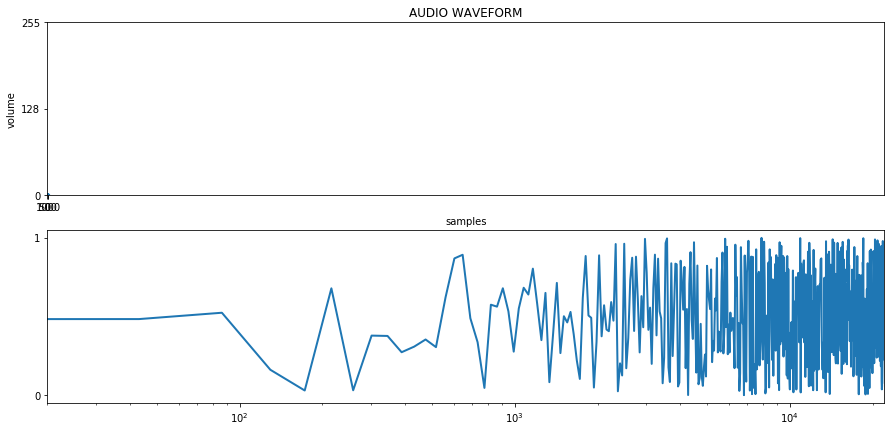

In [3]:
    # x variables for plotting
    x = np.arange(0, 2 * CollectedAudio.CHUNK, 2)
    xf = np.linspace(0, CollectedAudio.RATE, CollectedAudio.CHUNK)
    # self.Rate = R_Unambg = stop, len_PRI = rate

    # create matplotlib figure and axes
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 7))

    # create a line object with random data
    line, = ax1.plot(x, np.random.rand(CollectedAudio.CHUNK), '-', lw=2)

    # create semilogx line for spectrum
    line_fft, = ax2.semilogx(
        xf, np.random.rand(CollectedAudio.CHUNK), '-', lw=2)

            # format waveform axes
    ax1.set_title('AUDIO WAVEFORM')
    ax1.set_xlabel('samples')
    ax1.set_ylabel('volume')
    ax1.set_ylim(0, 255)
    ax1.set_xlim(0, 2 * CollectedAudio.CHUNK * CollectedAudio.frame_max)
    plt.setp(
        ax1, yticks=[0, 128, 255],
        xticks=[0, CollectedAudio.frame_max, 2 * CollectedAudio.frame_max],
    )
    plt.setp(ax2, yticks=[0, 1],)

    # format spectrum axes
    ax2.set_xlim(20, CollectedAudio.RATE / 2)



In [4]:
# -------------------------------
# Detection Section
# Envelope detect the signals
len_PRI = CollectedAudio.CHUNK * 1
# main_trace_env = det.envelope(CollectedAudio.data_np2) # Replace with X Corr
main_trace_env = CollectedAudio.data_np2

# -------------------------------
# Gate the signal & sum them up for 
# provide n observation effects
n_obs_main_trace_env = main_trace_env.reshape(CollectedAudio.frame_max, len_PRI)
# n_obs_main_trace_env = main_trace_env

# add them all together
n_obs_main_trace_env = n_obs_main_trace_env.sum(axis=0)

display(n_obs_main_trace_env)
display(len(n_obs_main_trace_env))

array([129361, 127658, 126207, ..., 128007, 126695, 127132])

1024

In [5]:
from scipy.signal import find_peaks

dBm = -100 #dBm
#scalar = 1e-3 * np.power(10,(dBm/10))
scalar = 2500
#height = scalar

peaks, _ = find_peaks(n_obs_main_trace_env, height=scalar, distance=1e3)
# peaks2 = np.clip(n_obs_main_trace_env, a_min=scalar, a_max=None)
# peaks2 = peaks * R_unamb/(len(n_obs_main_trace_env))
# display(R_unamb/(len(n_obs_main_trace_env)))
# display(R_unamb/len_PRI)
# display(len_PRI)
# target_ranges.sort()
display(peaks) # Indices
# display(target_ranges)

# Dont use clips...build own clips?

array([764], dtype=int64)

Text(0, 0.5, 'Power in Watts')

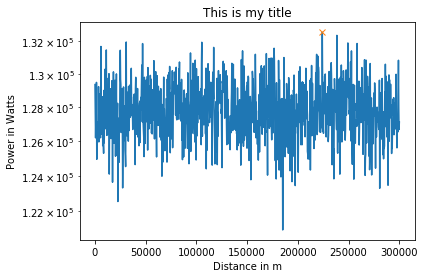

In [6]:
# make the distance vector
R_unamb = 3e8
nsamps = len(n_obs_main_trace_env)
x = np.linspace(0,R_unamb, nsamps)
dx = R_unamb/(len(n_obs_main_trace_env))

plt.semilogy(x/1e3,n_obs_main_trace_env)
plt.semilogy(peaks*dx/1e3,n_obs_main_trace_env[peaks], 'x')
plt.title('This is my title')
plt.xlabel('Distance in m')
plt.ylabel('Power in Watts')